# Machine Learning: Regression

*Whereof what's past is prologue* - Shakespeare

We explore supervised machine learning and regression models for macroeconomic forecasting, with a focus on predicting the industrial production index (INDPRO) using a wide range of economic indicators. To improve generalization and predictive performance, we investigate methods such as subset selection, penalized regression, decision trees, and ensemble learning, aiming to strike a balance between model complexity and accuracy.


In [116]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error    
from finds.readers.alfred import Alfred, fred_md
from finds.utils import plot_date
from secret import credentials
# %matplotlib qt
VERBOSE = 0

## Macroeconomic forecasting

For the candidate regression models, the independent variables consist of up to three lags of each economic indicator. The objective is to predict the rate of change in the industrial production index (INDPRO) for the following month while minimizing the **mean squared error (MSE)** loss function, which is appropriate for continuous-valued targets.

Monthly macroeconomic data is retrieved from FRED-MD, with any missing recent values supplemented from other public sources. Suggested transformations are applied to each time series to ensure stationarity. The pre-2023 period is used for training, while the post-2023 period is reserved for testing.


In [117]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=-1)

In [ ]:
# Get latest FRED-MD data
freq = 'M' 
beg = 19640701  # 19620701
df, t = fred_md()   # 
transforms = t['transform']
end = df.index[-2]
split_date = end - 20000
print("Train/test date ranges:", beg, split_date, end)

FRED-MD vintage: monthly/current.csv
Train/test date ranges: 19640701 20221231 20241231


In [119]:
# Splice in common updates: source of PE ratio, Commercial Paper
for col in ['S&P PE ratio']:
    df[col] = alf.splice(col)
df['COMPAPFF'] = df['COMPAPFF'].ffill()  # forward fill 20200430
df['CP3M'] = df['CP3M'].ffill()          # forward fill 20200430

In [120]:
# Apply time series transformations according to FRED-MD
transformed = []
for col in df.columns:
    transformed.append(alf.transform(df[col], tcode=transforms[col], freq=freq))
data = pd.concat(transformed, axis=1).iloc[2:]
c = list(data.columns)
data = data.loc[(data.index >= beg) & (data.index <= end)]

In [121]:
# Drop columns with missing data
missing = []
for series_id in df.columns:
    g = data[series_id].notna()
    missing.extend([(date, series_id) for date in data.index[~g]])
missing_per_row = data.isna().sum(axis=1)
missing = DataFrame.from_records(missing, columns=['date', 'series_id'])
print('original:', data.shape, 'dropna:', data.dropna(axis=1).shape)
data = data.dropna(axis=1)   # drop columns where missing values
print(missing['series_id'].value_counts())
data

original: (726, 126) dropna: (726, 122)
series_id
ACOGNO          332
UMCSENT         163
TWEXAFEGSMTH    103
ANDENO           44
Name: count, dtype: int64


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLS
19640731,0.005422,0.005404,0.007343,0.019986,0.004947,0.006552,0.010342,0.011313,0.014079,0.016438,...,0.000667,-0.000369,-0.000090,-0.000016,0.003231,-0.004158,-0.003798,-0.002430,-0.002831,11.2238
19640831,0.005644,0.006061,0.005992,-0.020139,0.013974,0.006506,-0.000936,-0.000939,-0.001865,0.007219,...,-0.002031,-0.002398,0.001406,-0.000016,-0.003263,0.004141,-0.005958,-0.001818,0.011673,13.6898
19640930,0.004123,0.004205,-0.004164,0.027173,0.009372,0.003703,-0.004690,-0.003759,-0.011267,-0.023656,...,0.000728,0.003749,-0.001674,-0.000015,-0.006462,0.004090,-0.011142,-0.003802,0.010582,10.5167
19641031,0.000555,0.000650,0.006499,-0.013866,-0.039421,-0.013947,-0.010404,-0.013269,-0.020030,-0.109875,...,-0.001712,-0.002344,0.000525,-0.011757,0.016093,-0.024760,0.005974,-0.000704,-0.003579,11.0924
19641130,0.006703,0.007352,-0.009111,-0.009745,0.009335,0.030429,0.029043,0.031929,0.036884,0.128121,...,0.004137,0.000985,-0.000352,0.011772,-0.019272,0.024828,-0.009946,-0.002806,-0.002694,12.0087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240831,0.000066,-0.000117,0.000711,0.000375,-0.001144,0.004869,0.004515,0.007094,0.009218,0.047547,...,0.000600,-0.002222,-0.000061,-0.002580,0.001376,-0.006110,-0.001974,-0.000766,0.001445,19.6750
20240930,0.001458,0.000240,0.005257,0.007155,0.008903,-0.004205,-0.005809,-0.008928,-0.002317,-0.001441,...,0.005721,-0.002598,0.000553,0.004137,0.001906,0.004652,-0.002368,-0.001586,-0.001644,17.6597
20241031,0.003690,0.003488,0.001757,-0.001714,0.005575,-0.004547,-0.007220,-0.010970,-0.006158,-0.028598,...,-0.002965,0.003609,0.000788,-0.003839,-0.005006,-0.002154,-0.000146,0.003227,-0.000473,19.9478
20241130,0.002184,0.002756,0.004346,0.003993,0.006484,-0.001453,-0.001180,-0.000155,-0.004246,0.018794,...,-0.000986,0.000117,-0.002176,-0.000639,-0.002760,0.003190,-0.000872,-0.001679,-0.011753,15.9822


Data beyond the split date is excluded from model training to ensure a proper evaluation of generalization performance.

In [122]:
# Split time series train and test set
def ts_split(X, Y, end=split_date):
    """helper to split train/test time series"""
    return X[Y.index<=end], X[Y.index>end], Y[Y.index<=end], Y[Y.index>end]

In [123]:
def columns_map(columns, lag):
    """helper to create lagged column names"""
    return {col: col + '_' + str(lag) for col in columns}

In [124]:
def columns_unmap(columns):
    """helper to extract lagged column names"""
    cols = [col.split('_') for col in columns]
    return [col[0] for col in cols], [int(col[1]) for col in cols]

In [125]:
target_id = 'INDPRO'
lags = 3   # Include up to 3 lags of exogs
Y = data[target_id].iloc[lags:]
X = pd.concat([data.shift(lag).iloc[lags:]\
               .rename(columns=columns_map(data.columns, lag))
               for lag in range(1, lags+1)],
              axis=1)
                      

In [126]:
# new table to collect final fitted models
test = Series(name='test', dtype=float)    # collect test and train errors
train = Series(name='train', dtype=float)
final_models = {}  

## Regression models

Complex regression models with numerous features or parameters risk overfitting, capturing noise rather than true patterns. Several techniques help mitigate overfitting and improve model generalization:

- **Cross-validation**: Hyperparameter tuning using cross-validation helps ensure models generalize well across different data subsets. **K-fold Cross-Validation (K-fold CV)** divides the dataset into $K$ parts, training the model on $K-1$ sections and testing it on the remaining part, iterating through all folds and averaging results. **Leave-One-Out Cross-Validation (LOOCV)** is a special case where each data point serves as the test set once, helping refine hyperparameter selection.
  
- **Information criteria penalty**: The **Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC)** aid model selection by balancing goodness of fit and complexity. AIC, defined as $AIC = 2k - 2\ln(L)$, where $k$ is the number of parameters and $L$ is the likelihood, favors models that explain the data with minimal complexity. BIC, given by $BIC = k\ln(n) - 2\ln(L)$, introduces a stronger penalty for sample size $n$, preferring simpler models for large datasets. Lower AIC or BIC values indicate better models.
  
- **Ensemble learning**: By combining multiple weak learners, ensemble methods enhance model robustness. Bagging averages predictions from multiple models trained on different data subsets, reducing variance. Boosting sequentially corrects model errors, improving overall accuracy.


### Forward Subset Selection

**Forward Subset Regression** is a stepwise variable selection method used in regression modeling to identify the best subset of predictors. It begins with no variables in the model and iteratively adds the most significant predictor at each step, based on a chosen criterion, and stops when adding more variables does not significantly improve model performance. Penalized selection criteria, such as AIC or BIC, helps avoid overfitting. Forward selection is computationally more efficient than exhaustive search methods but may miss the optimal subset if an initially excluded variable becomes relevant later in combination with others.




In [127]:
def forward_select(Y, X, selected, ic='aic'):
    """helper to forward select next regressor, using sm.OLS"""
    remaining = [x for x in X.columns if x not in selected]
    results = []
    for x in remaining:
        r = sm.OLS(Y, X[selected + [x]]).fit()
        results.append({'select': x,
                        'aic': r.aic,
                        'bic': r.bic,
                        'rsquared': r.rsquared,
                        'rsquared_adj': r.rsquared_adj})
    return DataFrame(results).sort_values(by=ic).iloc[0].to_dict()

In [128]:
# find best bic, and show selection criteria scores
ic = 'bic'   # select by information criterion
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
selected = []
models = {}
for i in range(1, 32):
    select = forward_select(Y_train,
                            X_train,
                            selected,
                            ic=ic)
    models[i] = select
    selected.append(select['select'])
selected = DataFrame.from_dict(models, orient='index')
best = selected[[ic]].iloc[selected[ic].argmin()]
subset = selected.loc[:best.name].round(3)
subset.index = [alf.header(s.split('_')[0]) for s in subset['select']]
print('Forward Selection Subset')
subset

Forward Selection Subset


,select,aic,bic,rsquared,rsquared_adj
Initial Claims,CLAIMS_1,-4772.162,-4767.612,0.355,0.354
Real M2 Money Stock,M2REAL_2,-4814.414,-4805.315,0.394,0.393
"All Employees, Wholesale Trade",USWTRADE_2,-4843.063,-4829.414,0.420,0.418
"All Employees, Service-Providing",SRVPRD_2,-4864.114,-4845.916,0.439,0.436
5-Year Treasury Constant Maturity Minus Federal Funds Rate,T5YFFM_3,-4881.249,-4858.500,0.454,0.450
Total Business: Inventories to Sales Ratio,ISRATIO_2,-4895.191,-4867.893,0.467,0.462
"All Employees, Service-Providing",SRVPRD_1,-4911.828,-4879.981,0.481,0.475
"All Employees, Financial Activities",USFIRE_2,-4928.888,-4892.490,0.495,0.489
"All Employees, Trade, Transportation, and Utilities",USTPU_1,-4945.576,-4904.629,0.508,0.502
"Consumer Motor Vehicle Loans Owned by Finance Companies, Level",DTCOLNVHFNM_3,-4952.630,-4907.133,0.514,0.507


In [129]:
DataFrame.from_dict({n: {'series_id': s.split('_')[0],
                         'lag' : s.split('_')[1],
                         'description': alf.header(s.split('_')[0])}
                     for n, s in selected.loc[:best.name, 'select'].items()},
                    orient='index').set_index('series_id')

,lag,description
series_id,,
CLAIMS,1,Initial Claims
M2REAL,2,Real M2 Money Stock
USWTRADE,2,"All Employees, Wholesale Trade"
SRVPRD,2,"All Employees, Service-Providing"
T5YFFM,3,5-Year Treasury Constant Maturity Minus Federa...
ISRATIO,2,Total Business: Inventories to Sales Ratio
SRVPRD,1,"All Employees, Service-Providing"
USFIRE,2,"All Employees, Financial Activities"
USTPU,1,"All Employees, Trade, Transportation, and Util..."


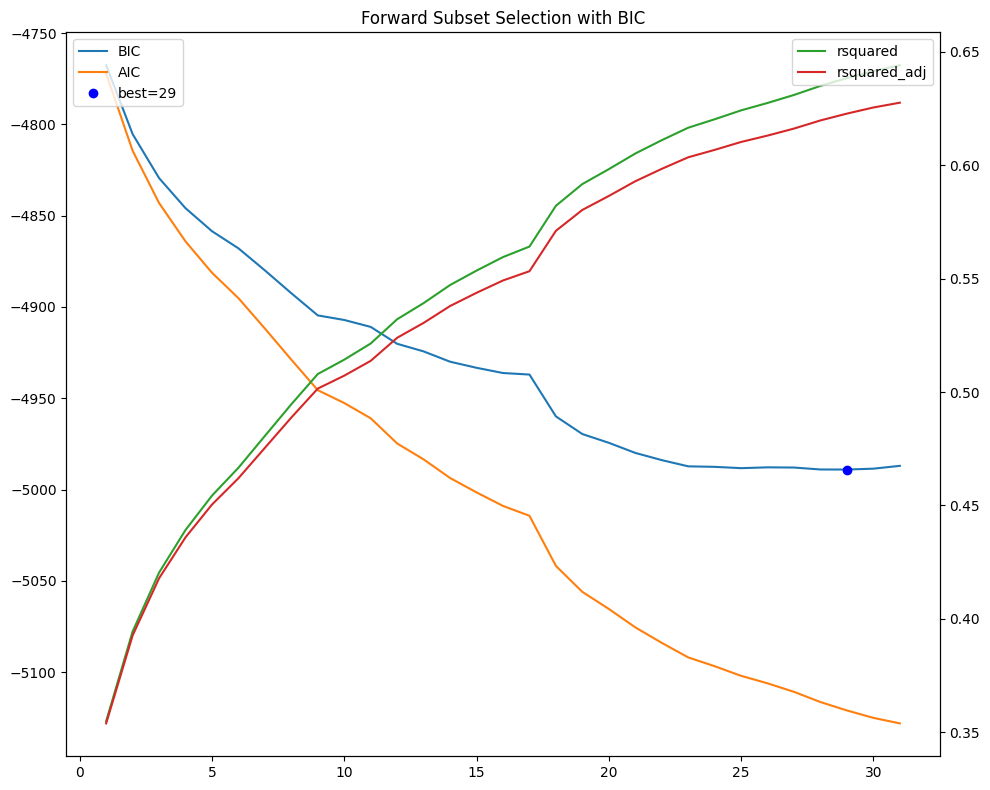

In [130]:
# Plot BIC vs number selected
fig, ax = plt.subplots(num=1, figsize=(10, 8))
selected['bic'].plot(ax=ax, c='C0')
selected['aic'].plot(ax=ax, c='C1')
ax.plot(best.name, float(best.iloc[0]), "ob")
ax.legend(['BIC', 'AIC', f"best={best.name}"], loc='upper left')
ax.set_title(f"Forward Subset Selection with {ic.upper()}")
bx = ax.twinx()
selected['rsquared'].plot(ax=bx, c='C2')
selected['rsquared_adj'].plot(ax=bx, c='C3')
bx.legend(['rsquared', 'rsquared_adj'], loc='upper right')
bx.set_xlabel('# Predictors')
plt.tight_layout()

In [131]:
# evaluate train and test mse
X_subset = X_train[subset['select']]
model = sm.OLS(Y_train, X_subset).fit()
name = f"Forward Subset Regression (k={len(subset)})"
Y_pred = model.predict(X_test[subset['select']])
test[name] = mean_squared_error(Y_test, Y_pred)                               
train[name] = mean_squared_error(Y_train, model.predict(X_subset))
final_models[name] = model

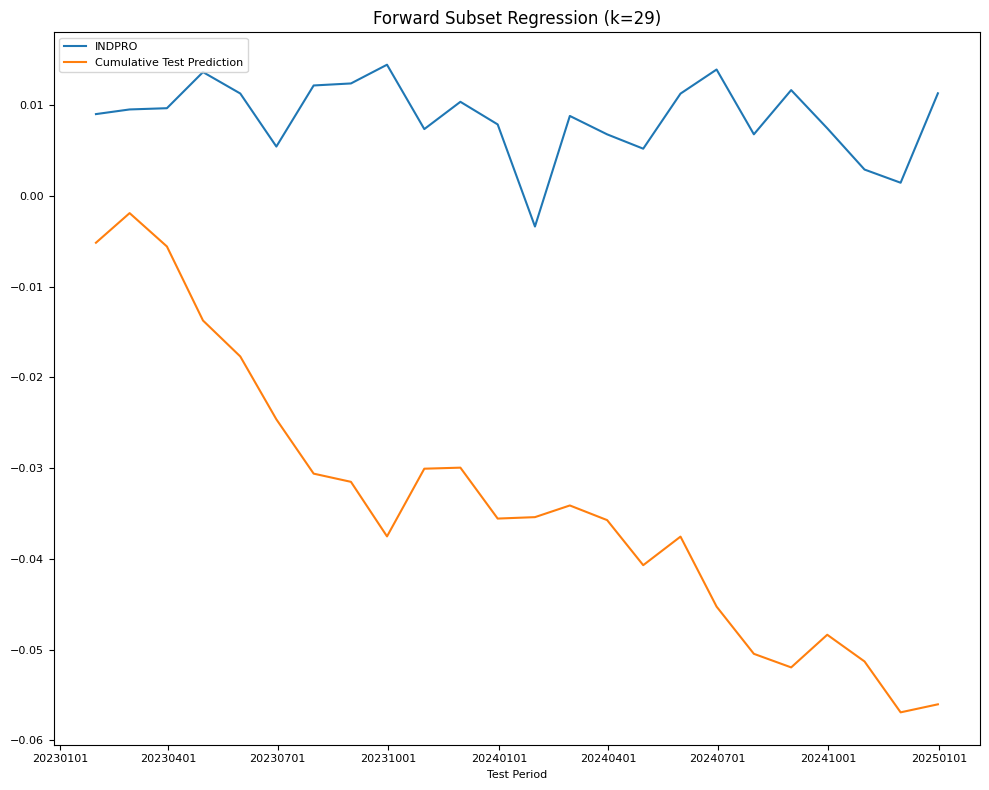

In [132]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [133]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Forward Subset Regression (k=29),0.005955,0.007674


### Partial Least Squares Regression

Partial Least Squares (PLS) Regression combines features of principal component analysis (PCA) and multiple linear regression. PLS constructs new latent variables (components) as linear combinations of the original predictors that maximize covariance with the response variable. The number of components (`n_components`) parameter controls the dimensionality reduction and must be chosen carefully to balance bias-variance tradeoff. This method is particularly useful when datasets have more predictors than observations and strong multicollinearity.


In [134]:

# split train and test, fit standard scaling using train set
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [135]:
# fit with 5-fold CV to choose n_components
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in np.arange(2, 31):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(estimator=pls,
                            X=X_train,
                            y=Y_train,
                            n_jobs=5,
                            verbose=VERBOSE,
                            cv=kf,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

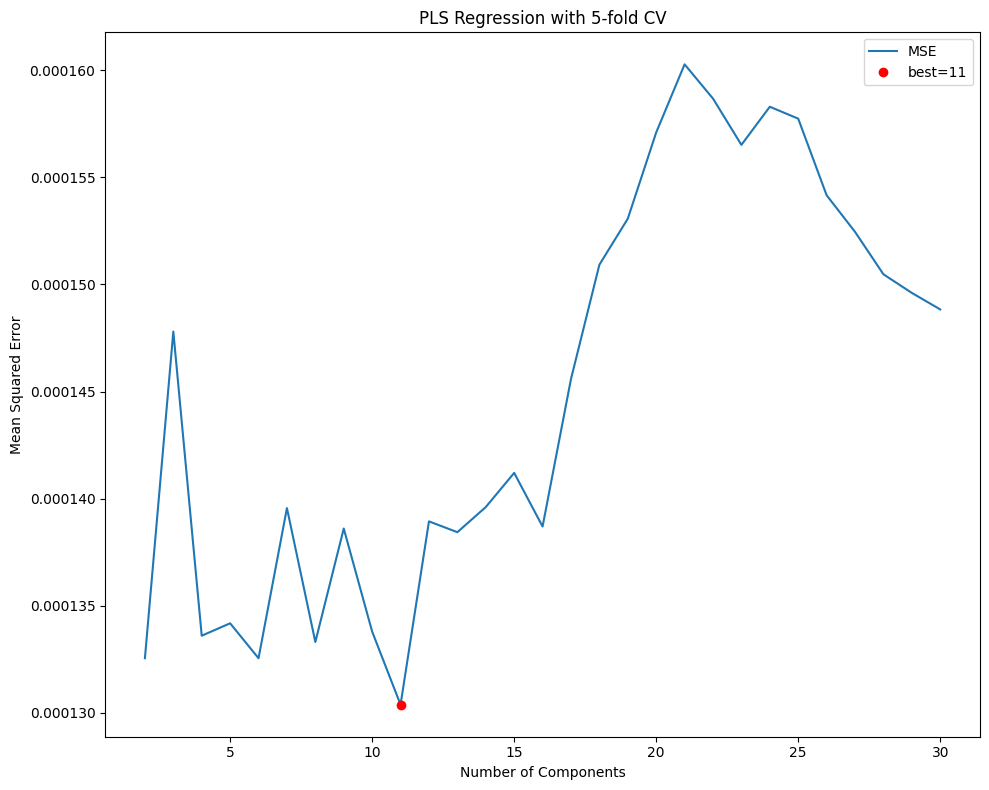

In [136]:
# show cross-validation results and best model
fig, ax = plt.subplots(figsize=(10, 8))
mse.plot(ylabel='Mean Squared Error',
         xlabel='Number of Components',
         title=f"PLS Regression with {n_splits}-fold CV",
         ax=ax)
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['MSE', f"best={best}"])
plt.tight_layout()

In [137]:
### evaluate train and test mse
model = PLSRegression(n_components=best).fit(X_train, Y_train)
name = f"PLS Regression(k={best})"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))

In [138]:
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

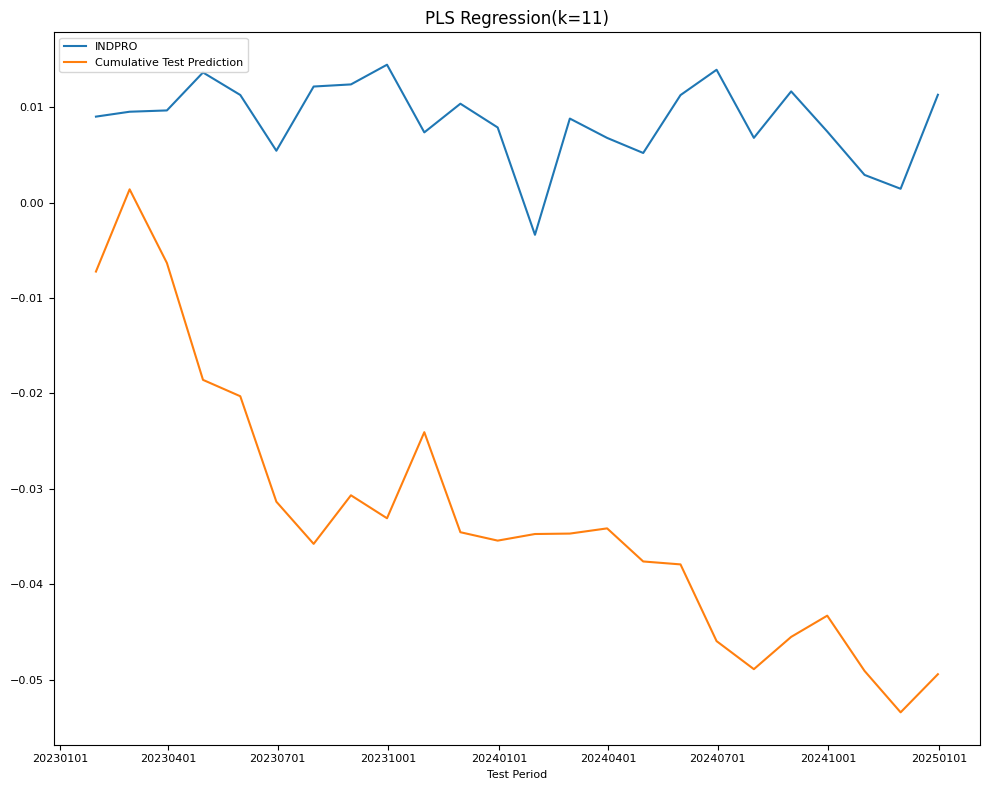

In [139]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [140]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,PLS Regression(k=11),0.005306,0.008791


### Ridge Regression

Ridge Regression is a linear regression model that includes L2 regularization, which helps prevent overfitting by adding a penalty term to the loss function. The objective function is modified as follows:  

$$
\min_w ||y - Xw||^2 + \lambda ||w||^2
$$

where $||y - Xw||^2$ is the standard least squares error, and $\lambda ||w||^2$ is the penalty term that shrinks the model coefficients $w$ towards zero. The $\lambda$ parameter (`alpha` in `sklearn`'s `Ridge`) controls the strength of regularization: larger values reduce model complexity by forcing coefficients to be smaller, while smaller values make Ridge behave like standard linear regression. Ridge retains all features but reduces their impact, which is useful when dealing with multicollinearity, without completely eliminating any predictor.


In [141]:
from sklearn.linear_model import Ridge, RidgeCV
alphas = 10**np.linspace(5, -4, 100)*0.5  # for parameter tuning
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)
np.random.seed(42)

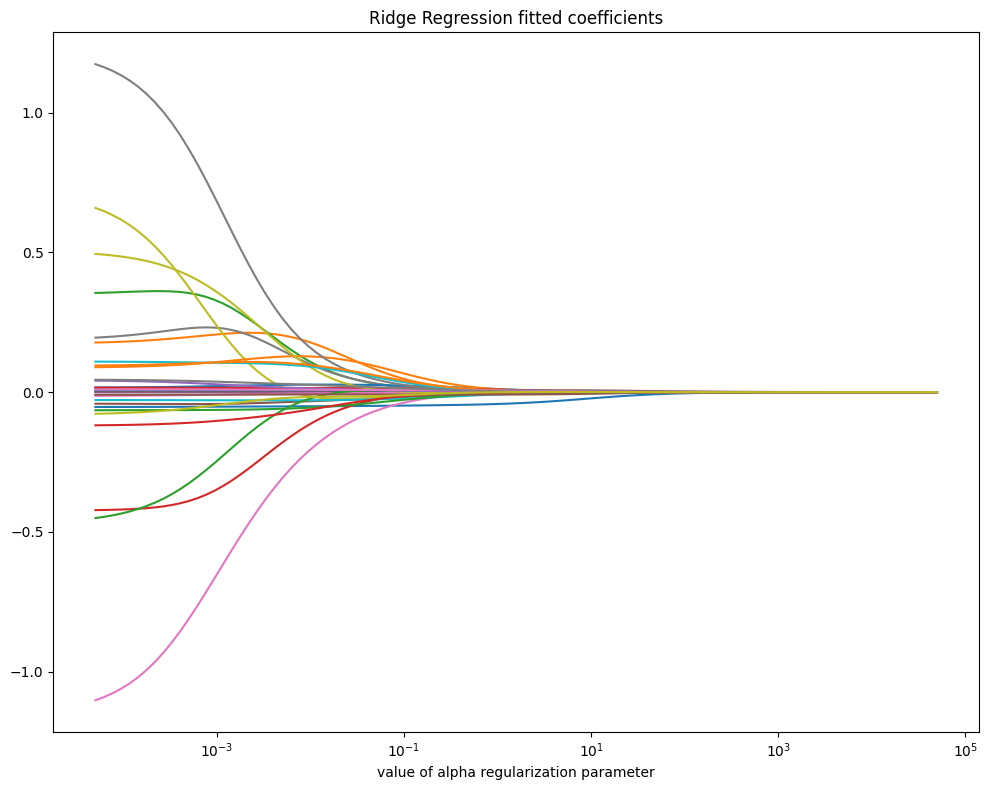

In [142]:
# Plot fitted coefficients vs regularization alpha
coefs = [Ridge(alpha, fit_intercept=False)\
         .fit(X_subset, Y_train).coef_ for alpha in alphas]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('value of alpha regularization parameter')
ax.set_title('Ridge Regression fitted coefficients')
plt.tight_layout()

In [143]:
# RidgeCV LOOCV
model = RidgeCV(alphas=alphas,
                scoring='neg_mean_squared_error',
                cv=None,  # to use Leave-One-Out cross validation
                store_cv_values=True).fit(X_train, Y_train)

In [144]:
name = f"Ridge (alpha={model.alpha_:.1f})"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

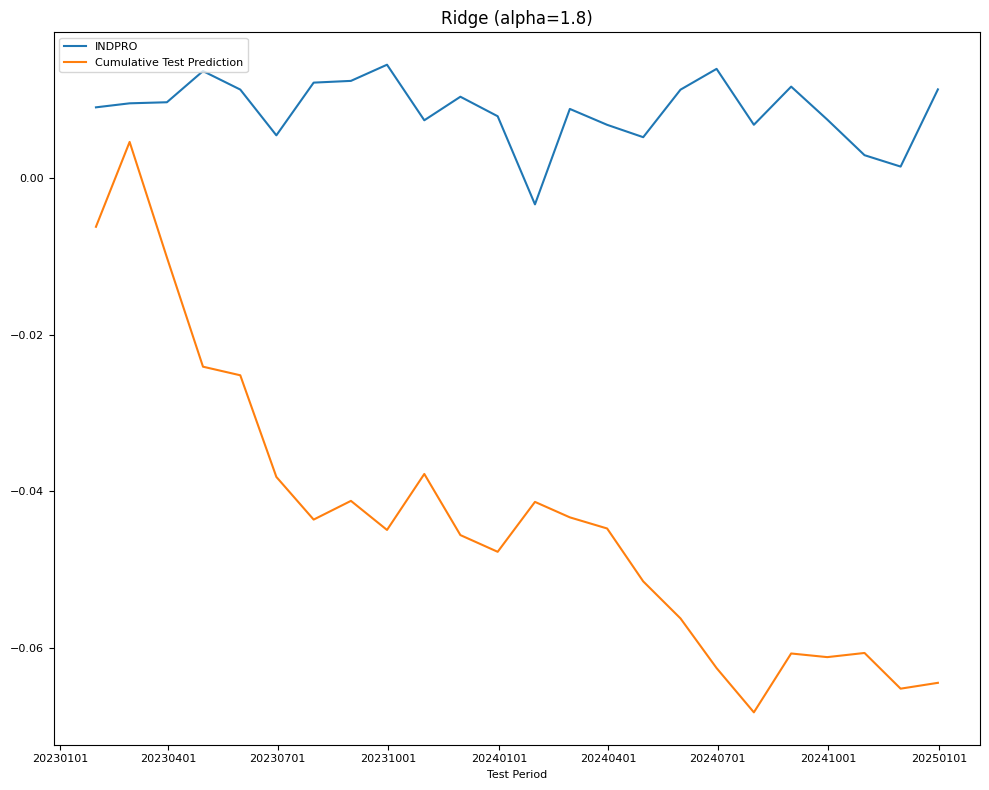

In [145]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [146]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Ridge (alpha=1.8),0.004305,0.009825


###  Lasso Regression

Lasso Regression (Least Absolute Shrinkage and Selection Operator) is a linear regression model that includes **L1 regularization**, which adds the sum of the absolute values of the coefficients as a penalty term to the loss function. This encourages sparsity, meaning it shrinks some coefficients to exactly zero, effectively performing feature selection. The objective function is:  

$$
\min_w ||y - Xw||^2_2 + \alpha ||w||_1
$$

where $\alpha$ is a hyperparameter controlling the strength of regularization: a higher $\alpha$ increases shrinkage, leading to more coefficients being set to zero. Lasso regression is particularly useful when dealing with high-dimensional data where many features may be irrelevant, by reducing model complexity and improving interpretability. However, with correlated features, it tends to arbitrarily select one and ignore the others.

In [147]:
from sklearn.linear_model import Lasso, LassoCV
alphas = 10**np.linspace(-2, -9, 100)*0.5  # for parameter tuning
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

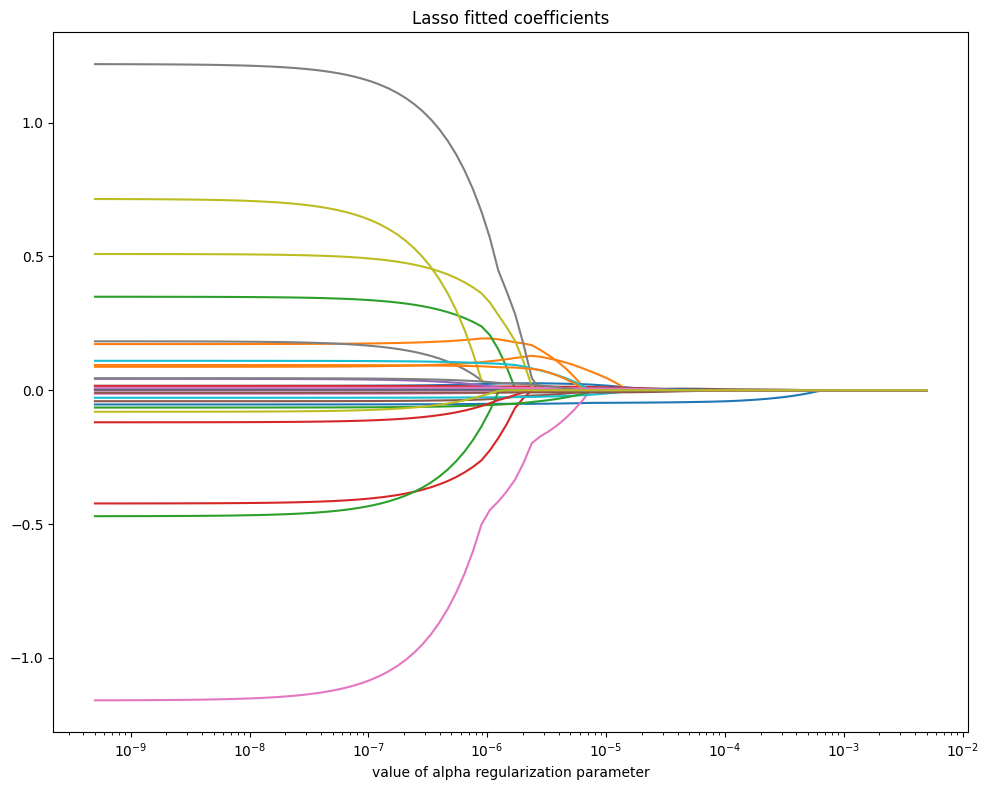

In [148]:
# Plot fitted coefficients vs regularization
coefs = [Lasso(max_iter=10000, alpha=alpha)\
         .fit(X_subset, Y_train).coef_  for alpha in alphas]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('value of alpha regularization parameter')
ax.set_title('Lasso fitted coefficients')
plt.tight_layout()

In [149]:
# LassoCV 10-Fold CV
model = LassoCV(alphas=None,
                cv=5,
                n_jobs=5,
                verbose=VERBOSE,
                max_iter=20000).fit(X_train, Y_train)
name = f"Lasso (alpha={model.alpha_:.3g})"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

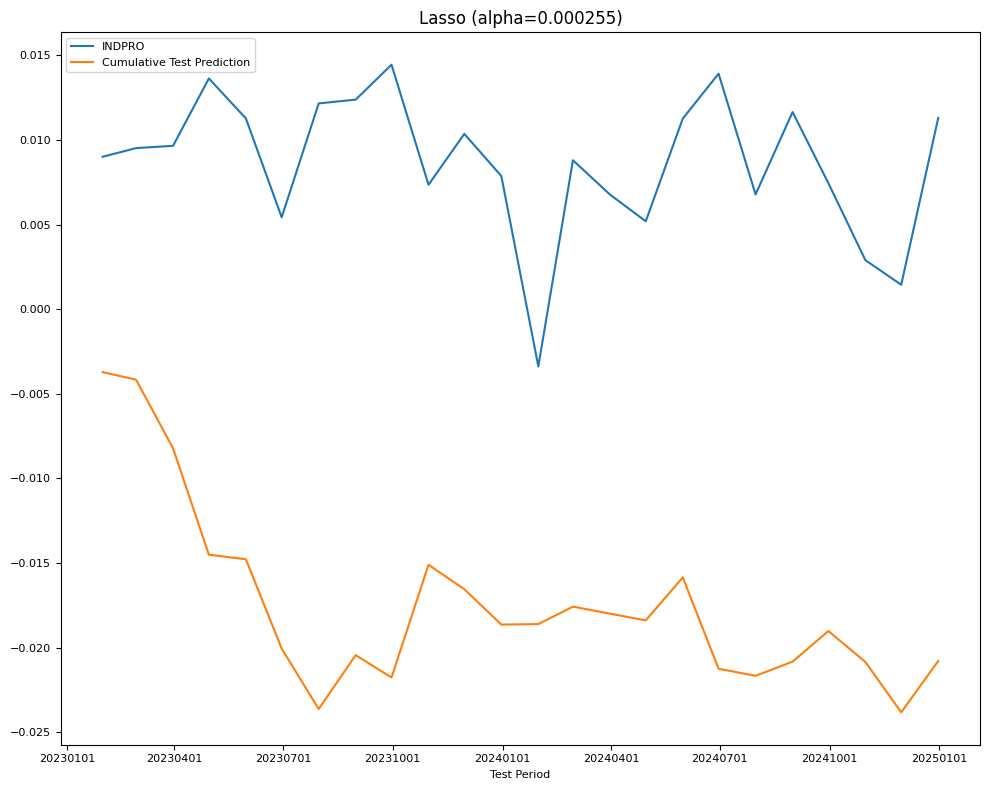

In [150]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [151]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Lasso (alpha=0.000255),0.006279,0.006808


In [152]:
# Display nonzero coefs
nonzero = np.sum(np.abs(model.coef_) > 0)
argsort = np.flip(np.argsort(np.abs(model.coef_)))[:nonzero]
df = DataFrame({'series_id': columns_unmap(X.columns[argsort])[0],
                'lags': columns_unmap(X.columns[argsort])[1],
                'desc': [alf.header(s)
                         for s in columns_unmap(X.columns[argsort])[0]],
                'coef': model.coef_[argsort]}).round(6).set_index('series_id')
print("Lasso: Nonzero Coefficients")
df

Lasso: Nonzero Coefficients


,lags,desc,coef
series_id,,,
CLAIMS,1,Initial Claims,-0.005356
SRVPRD,1,"All Employees, Service-Providing",-0.001268
M2REAL,2,Real M2 Money Stock,0.000893
IPNMAT,3,Industrial Production: Nondurable Goods Materials,0.000751
USGOVT,1,"All Employees, Government",-0.000716
...,...,...,...
M2SL,3,M2,0.000020
COMPAPFF,3,3-Month Commercial Paper Minus FEDFUNDS,-0.000020
UEMPLT5,3,Number Unemployed for Less Than 5 Weeks,0.000019


### Decision Tree

Decision trees partition the predictor space into regions, making predictions based on mean values (for regression) or mode (for classification).

- A **decision tree** consists of a sequence of splitting rules that divide observations into different regions. These trees are typically drawn upside down, with the leaves at the bottom.  
- **Terminal nodes** or **leaves** represent the final partitions of the predictor space where observations are grouped.  
- **Internal nodes** are points in the tree where the predictor space is split.  
- **Branches** connect the nodes and represent different decision paths.  
- A **stump** refers to a decision tree with only a single split (one internal node).  

Decision trees are constructed using **recursive binary splitting**, a top-down, greedy algorithm. The process begins with all observations in a single region, and at each step, the predictor space is split into two new branches based on the best possible split at that moment (without considering future steps). The best split is determined by selecting the predictor and cutpoint that minimize a chosen cost function, such as the **Residual Sum of Squares (RSS)** in regression. The process continues recursively until a stopping criterion is met, such as a minimum number of observations per node.  

Growing a tree until all leaves are pure (containing only one class) often leads to overfitting. Tree complexity is measured by the number of nodes, and controlling this complexity is crucial. If trees are allowed to grow too large, they may fit the training data well but perform poorly on unseen data. A balance must be found where accuracy on the test set is maximized before further tree growth begins to decrease performance.  

Overfitting can be mitigated by pruning the tree using cost complexity pruning. A fully grown tree is simplified by removing less important splits to minimize the following function:

$$\sum_{m=1}^{|T|} \sum_{x_i \in R_m} (y_i - \hat{y}_{R_m})^2 + \alpha |T|
$$

where $|T|$ is the number of terminal nodes, $R_m$ represents a region in the predictor space, and $\hat{y}_{R_m}$ is the predicted response for that region. Pruning is controlled by a tuning parameter $\alpha$, where higher values result in smaller trees that generalize better.  

For classification tasks, different impurity measures determine the best binary splits:  

- **Classification error rate**: Measures the proportion of incorrectly classified observations in a node. While intuitive, it is not sensitive enough for effective tree growth.  

$$
\hat{\rho}_{m,c} = \frac{n_{m,c}}{n_m}
$$

where $n_m$ is the number of observations in node $m$ and $n_{m,c}$ is the number of observations in node $m$ belonging to class $c$.  

- **Gini index**: Measures total variance across classes. A lower Gini index indicates that most observations in a node belong to a single class.  

$$
G = \sum_{k=1}^{K} \hat{\rho}_{mk} (1 - \hat{\rho}_{mk})
$$

where $\hat{\rho}_{mk}$ represents the proportion of training observations in node $m$ that belong to class $k$.  

- **Entropy**: Measures node impurity. Lower entropy values indicate purer nodes.  

$$
D = -\sum_{k=1}^{K} \hat{\rho}_{mk} \log \hat{\rho}_{mk}
$$


**Deviance** is a statistical measure used to assess model performance in classification problems. It is derived from the likelihood function and is a measure of how well the predicted probabilities match the actual class labels. It is calculated as:  

$$
Deviance = -2 \sum_{m=1}^{g} \sum_{c=1}^{w} n_{m,c} \ln \hat{p}_{m,c}
$$

where:  
- $g$ is the number of terminal nodes (leaf nodes) in the forest.  
- $w$ is the number of classes.  
- $n_{m,c}$ is the number of observations in node $m$ belonging to class $c$.  
- $\hat{p}_{m,c}$ is the predicted probability of class $c$ in node $m$.  

with the **residual mean deviance** given by: $\frac{\text{deviance}}{n - 1}$

A lower deviance indicates better model performance, meaning the predicted class probabilities align more closely with the true class labels.  

**Advantages:**  
- Easy to interpret and visualize, even for non-experts.  
- Often reflect human decision-making processes.  
- Can handle qualitative predictors without requiring dummy variables.  

**Disadvantages:**  
- Less accurate than some other regression and classification models.  
- Highly sensitive to small changes in data, making them non-robust.  
- Tend to overfit categorical variables.  

Decision tree performance can be significantly improved using **ensemble methods** such as:  

- **Bagging (Bootstrap Aggregating)**: Reduces variance by averaging predictions from multiple decision trees trained on different bootstrap samples.  
- **Random Forests**: A variant of bagging that introduces additional randomness by selecting a random subset of features at each split.  
- **Boosting**: Sequentially builds trees where each new tree corrects the errors of the previous ones, reducing bias and improving predictive performance.  

By aggregating multiple decision trees, these ensemble methods enhance generalization and reduce overfitting, making decision trees more robust and effective for complex predictive modeling.


### Gradient boosting

Gradient Boosting is an ensemble learning technique that builds models sequentially, where each new model corrects the errors of the previous ones. It uses decision trees as weak learners and minimizes the loss function by optimizing the model in the direction of the gradient of the loss. Key parameters include `n_estimators` (number of trees), `learning_rate` (step size for updates, controlling how much each tree contributes), and `max_depth` (tree depth, preventing overfitting). Gradient Boosting can be computationally expensive and prone to overfitting if not regularized using techniques like early stopping or shrinkage (learning_rate tuning).


In [153]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [154]:
# tune max_depth with 5-fold CV
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in range(1, 10): # tune max_depth for best performance
    boosted = GradientBoostingRegressor(max_depth=i, random_state=0)
    score = cross_val_score(boosted,
                            X_train,
                            Y_train,
                            cv=kf,
                            n_jobs=5,
                            verbose=VERBOSE,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

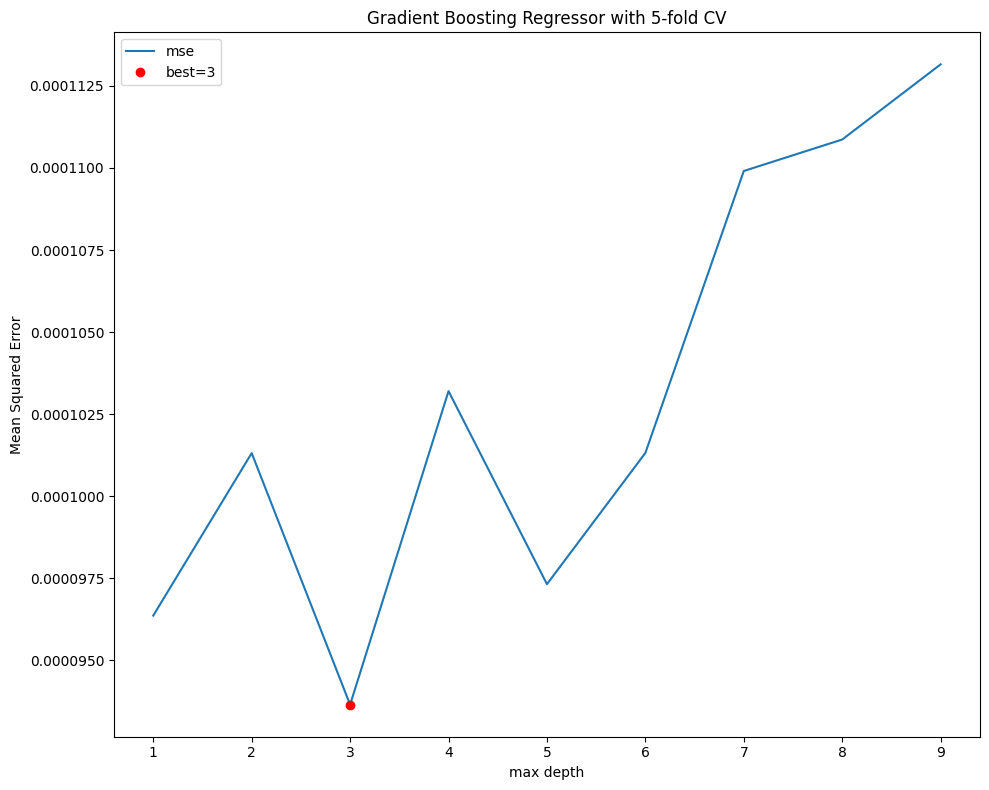

In [155]:
fig, ax = plt.subplots(figsize=(10, 8))
mse.plot(ax=ax, ylabel='Mean Squared Error', xlabel='max depth',
         title=f"Gradient Boosting Regressor with {n_splits}-fold CV")
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['mse', f"best={best}"])
plt.tight_layout()

In [156]:
# evaluate train and test MSE
name = f"Boosting (depth={best})"
model = GradientBoostingRegressor(max_depth=best,
                                  random_state=0).fit(X_train, Y_train)

In [157]:
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

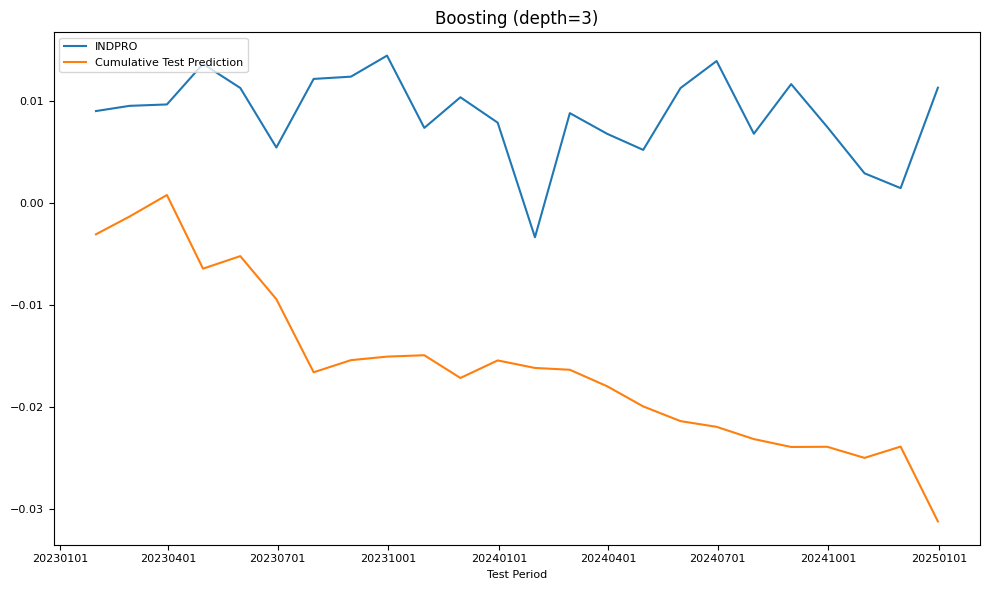

In [158]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [159]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Boosting (depth=3),0.002704,0.007407


__Feature importances__:

In [160]:
# Show feature importance
top_n = 10
imp = Series(model.feature_importances_, index=X.columns).sort_values()
print(f"Gradient Boosting: Top {top_n} Feature Importances")
DataFrame.from_dict({i+1: {'importance': imp[s],
                           'series_id': s.split('_')[0],
                           'lags': s.split('_')[1],
                           'description': alf.header(s.split('_')[0])}
                     for i, s in enumerate(np.flip(imp.index[-top_n:]))},
                    orient='index')

Gradient Boosting: Top 10 Feature Importances


,importance,series_id,lags,description
1,0.140886,BUSLOANS,1,"Commercial and Industrial Loans, All Commercia..."
2,0.136621,CLAIMS,1,Initial Claims
3,0.031817,UEMPLT5,3,Number Unemployed for Less Than 5 Weeks
4,0.030436,M2REAL,3,Real M2 Money Stock
5,0.029806,USGOOD,1,"All Employees, Goods-Producing"
6,0.027816,M2SL,1,M2
7,0.022606,IPNMAT,1,Industrial Production: Nondurable Goods Materials
8,0.020286,DMANEMP,1,"All Employees, Durable Goods"
9,0.019784,EXCAUS,1,Canadian Dollars to U.S. Dollar Spot Exchange ...
10,0.018134,UNRATE,1,Unemployment Rate


### Random Forest

**Random Forest** is an ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting. It operates by randomly selecting subsets of the training data and features (using bootstrap sampling and feature bagging) to create diverse trees. The final prediction is determined by majority voting (for classification) or averaging (for regression). Key parameters include `n_estimators` (number of trees), `max_depth`** (maximum depth of each tree), `max_features` (number of features considered for splitting), and `min_samples_split` (minimum samples needed to split a node). Feature importance scores can be extracted to interpret which variables influence predictions most. Random Forest handles missing data well and mitigates overfitting through averaging multiple models.


In [161]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, Y_train, Y_test = ts_split(X, Y)

In [162]:
# tune max_depth with 5-fold CV
n_splits=5
kf = KFold(n_splits=n_splits,
           shuffle=True,
           random_state=0)
mse = Series(dtype=float)
for i in range(3, 20): #tune for best performance
    model = RandomForestRegressor(max_depth=i, random_state=0)
    score = cross_val_score(model,
                            X_train,
                            Y_train,
                            cv=kf,
                            n_jobs=5,
                            verbose=VERBOSE,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score
    #print(i, np.sqrt(abs(score)))

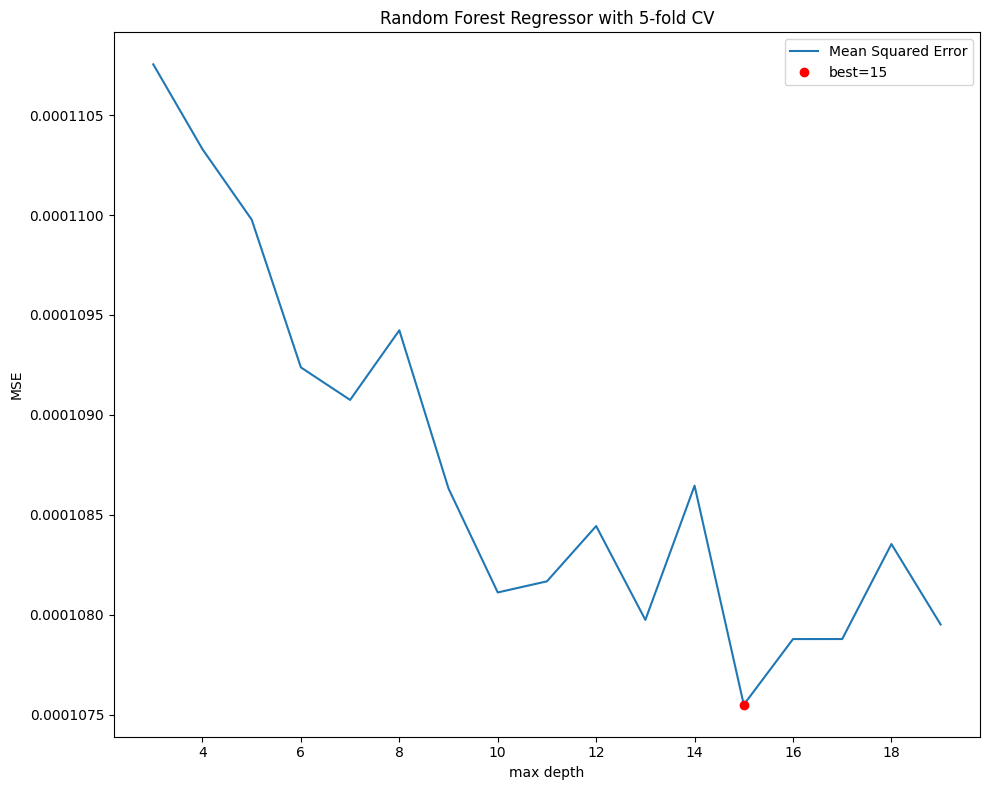

In [163]:
fig, ax = plt.subplots(figsize=(10, 8))
mse.plot(ax=ax, ylabel='MSE', xlabel='max depth',
         title=f"Random Forest Regressor with {n_splits}-fold CV")
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['Mean Squared Error', f"best={best}"])
plt.tight_layout()

In [164]:
name = f"RandomForest (depth={best})"
model = RandomForestRegressor(max_depth=best,
                              random_state=0).fit(X_train, Y_train)

In [165]:
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

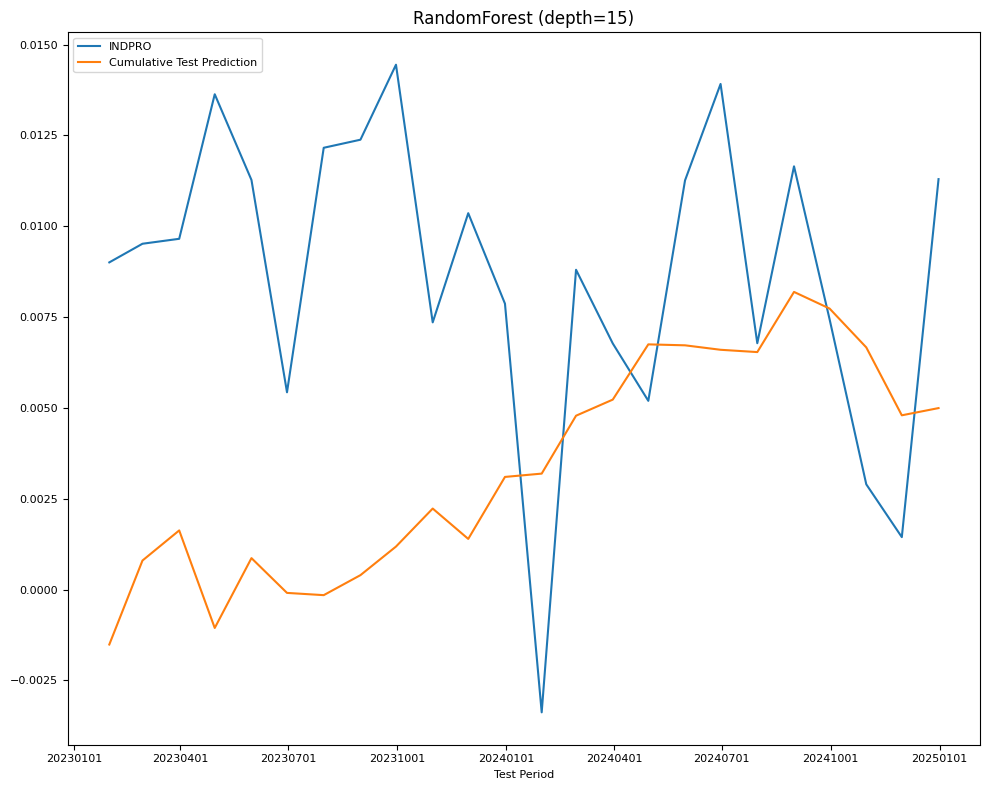

In [166]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [167]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,RandomForest (depth=15),0.00376,0.005875


__Feature importance__ scores:

In [168]:
# Feature importance
top_n = 10
imp = Series(model.feature_importances_, index=X.columns).sort_values()
print(f"Random Forest: Top {top_n} Feature Importances")
DataFrame.from_dict({i+1: {'importance': imp[s],
                          'series_id': s.split('_')[0],
                          'lags': s.split('_')[1],
                          'description': alf.header(s.split('_')[0])}
                    for i, s in enumerate(np.flip(imp.index[-top_n:]))},
                   orient='index')

Random Forest: Top 10 Feature Importances


,importance,series_id,lags,description
1,0.051226,CLAIMS,1,Initial Claims
2,0.046733,BUSLOANS,1,"Commercial and Industrial Loans, All Commercia..."
3,0.044055,M2SL,1,M2
4,0.015825,USGOOD,1,"All Employees, Goods-Producing"
5,0.015268,UNRATE,1,Unemployment Rate
6,0.014617,UEMPLT5,3,Number Unemployed for Less Than 5 Weeks
7,0.014576,IPCONGD,1,Industrial Production: Consumer Goods
8,0.014529,UEMPLT5,1,Number Unemployed for Less Than 5 Weeks
9,0.014496,M1SL,1,M1
10,0.013855,DMANEMP,1,"All Employees, Durable Goods"


__Summary:__

The **root mean squared error (RMSE)** performance of all the models, based on train and test samples, is summarized in the following chart:


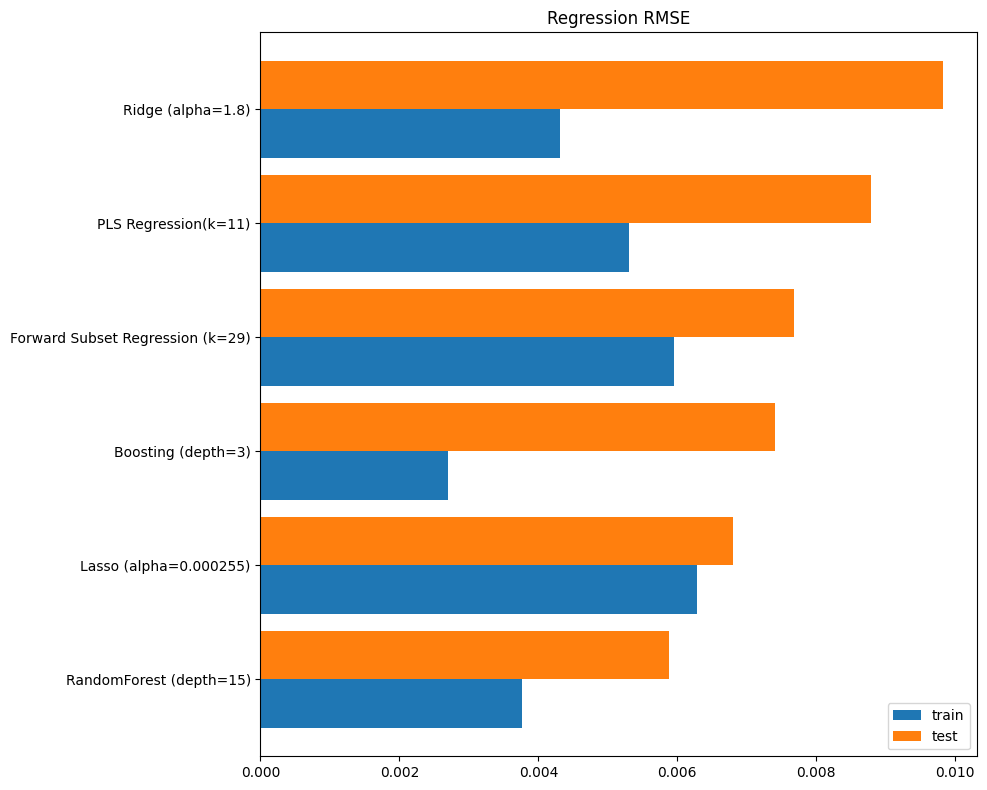

In [169]:
fig, ax = plt.subplots(figsize=(10, 8))
pd.concat([np.sqrt(r.to_frame()) for r in [train, test]], axis=1)\
  .sort_values('test')\
  .plot.barh(ax=ax, width=0.85)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Regression RMSE')
ax.figure.subplots_adjust(left=0.35)
plt.tight_layout()

__References:__

Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. "An Introduction to Statistical Learning with Applications in R". New York, Springer, 2013.